In [34]:
import requests
from bs4 import BeautifulSoup
import json
import re
import itertools
import time
import datetime
import random

request_count = 0 

# obtain last page by scraping from url given
def get_lastpage(link_url):
    global request_count
    request_count += 1
    mainresponse = requests.get(link_url)
    # print(mainresponse)
    mainsoup = BeautifulSoup(mainresponse.text, "html.parser")
    page_numbers = [item.text.strip().replace(" ","") for item in mainsoup.find_all("li", class_="e-page-number")]
    last_page = page_numbers[-1]
    return int(last_page)


#obtain car links for one page only 
def get_carlinks(url_link):
    global request_count
    request_count += 1
    url = 'https://proxy.scrapeops.io/v1/'
    params = {
        'api_key': '117dadb1-18cd-4761-a4e9-011b91e77b2d',
        'url': url_link,
    }
    response = requests.get(url, params=params)
    soup = BeautifulSoup(response.text, "html.parser")

    link_list = []
    for div in soup.find_all("div", class_="e-available m-has-photos"):
        for a in div.find_all("a", href=True):
            link = "https://www.autotrader.co.za" + a["href"]
            link_list.append(link)

    return (link_list)


def get_all_links(url):
    last_page = get_lastpage(url)
    if "pagenumber=" in url:
        # URL contains a page number, generate list of links based on page number
        base_url = url.split("pagenumber=")[0]
        links = [f"{base_url}pagenumber={i}&priceoption=RetailPrice" for i in range(1, last_page+1)]
    else:
        # URL does not contain a page number, assume it's for the first page
        base_url = url.split("?")[0]
        links = [f"{base_url}?pagenumber={i}&priceoption=RetailPrice" for i in range(1, last_page+1)]
    return links


# returns data scraped from a single page in json format
def autotrader_data(url_link):
    global request_count
    request_count += 1
    
    url = 'https://proxy.scrapeops.io/v1/'
    params = {
        'api_key': '117dadb1-18cd-4761-a4e9-011b91e77b2d',
        'url': url_link, 
    }
    
    response = requests.get(url=url, params=params)
    
    if response.status_code == 503:
        return f"Server Unavailable"
    else:
        soup = BeautifulSoup(response.text, "html.parser")

        components = url_link.split("/")

        brand = components[4]
        model = components[5]
        spec = components[6]

        # Get the text of the h1 with class "e-listing-title"
        
        full_title = soup.find("h1", class_="e-listing-title").text.strip().replace("For Sale", "")[5:].rstrip()

        #getting the primary key
        title = soup.title.text.strip()
        id = re.search("ID: (.*) - AutoTrader", title).group(1)

        # Get the text of the div with class "e-price"
        price = soup.find("div", class_="e-price").text.strip().replace("\xa0", " ").replace("R ","").replace(" ","")

        # Get the text of all the list items with class "e-summary-icon"
        text_list = [item.text.strip().replace("\xa0", "").replace(" km","") for item in soup.find_all("li", class_="e-summary-icon")]

        car_data = {
            "id": "AT" + id,
            "make": brand,
            "model": model,
            "spec": spec,
            "full_title": full_title,
            "price": price,
            "condition": text_list[0],
            "year": text_list[1],
            "km": text_list[2],
            "transmission": text_list[3],
            "fuel_type": text_list[4],
            "source": "AutoTrader",
            "link": url_link
        }

        # Get the text of all the divs with class "col-6" within the parent div
        parent_div = soup.find("div", class_="b-striped-specs")
        col_divs = parent_div.find_all("div", class_="col-6")
        more_specs = [col_div.text for col_div in col_divs]

        # Add each 2nd item in more_specs to car_data with the specified key values
        car_data["LastUpdated"] = more_specs[1]

        return car_data

def get_all_cardata(url):
    all_pages = get_all_links(url)
    all_cars = []
    for i in all_pages:
        all_cars += get_carlinks(i)
    return all_cars


In [76]:
links = get_all_cardata("https://www.autotrader.co.za/cars-for-sale/aston-martin/db9/v12/search?priceoption=RetailPrice")

print(links)



[]


In [74]:
for i in links:
    try: 
        print(autotrader_data(i))
    except AttributeError:
        continue

KeyboardInterrupt: 

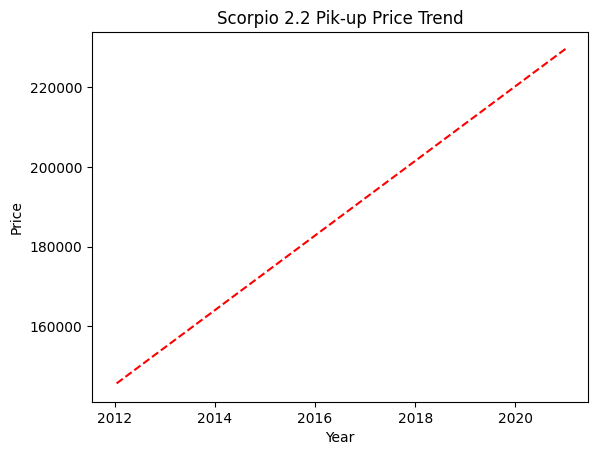

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the data from the csv file
data = pd.read_csv("scorpio.csv")

# Convert the 2022 year to a proper Date object with only year data
data['2022'] = pd.to_datetime(data['2022'], format='%Y')
data['year'] = data['2022'].dt.year

# Calculate the average of 239900 by year using the groupby function
avg_price = data.groupby('year')['239900'].mean().reset_index()

# Sort the data by year in descending order
avg_price = avg_price.sort_values('year', ascending=False)

# Rename the column to 'price'
avg_price = avg_price.rename(columns={'239900': 'price'})

# Set up the plot
fig, ax = plt.subplots()

# Add a line of best fit to the plot
z = np.polyfit(avg_price['year'], avg_price['price'], 1)
p = np.poly1d(z)
ax.plot(avg_price['year'], p(avg_price['year']), "r--")

# Set the plot title and axis labels
ax.set_title('Scorpio 2.2 Pik-up Price Trend')
ax.set_xlabel('Year')
ax.set_ylabel('Price')

# Show the plot
plt.show()


In [101]:
# Create a linear regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model to the data
model.fit(avg_price[['year']], avg_price['price'])

# Predict the price of a car from the year
year = int(input("enter future year")) # Input the year for which we want to predict the price
price = model.predict([[year]])[0]
print(f"The predicted price car {year} is {price:.2f}")

The predicted price car 2026 is 276466.63


C:\Users\calvi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [93]:
import csv
import json


def csv_to_car_data(csv_file):
    input_file = csv_file
    data = []
    with open(input_file, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            id, make, model, spec, full_title, price, condition, year, km, transmission, fuel_type, source, link = row
            item = {
                "id": id,
                "make": make,
                "model": model,
                "spec": spec,
                "full_title": full_title,
                "price": price,
                "condition": condition,
                "year": year,
                "km": km,
                "transmission": transmission,
                "fuel_type": fuel_type,
                "source": source,
                "link": link
            }
            data.append(item)
    return data

csv_to_car_data("hiluxD4D.csv")


[{'id': 'AT26747211',
  'make': 'toyota',
  'model': 'hilux',
  'spec': '2.5d-4d',
  'full_title': 'Toyota Hilux 2.5D-4D Double Cab Raider Legend 45',
  'price': '419990',
  'condition': 'Used Car',
  'year': '2015',
  'km': '234000',
  'transmission': 'Manual',
  'fuel_type': 'Diesel',
  'source': 'AutoTrader',
  'link': 'Link'},
 {'id': 'AT26894351',
  'make': 'toyota',
  'model': 'hilux',
  'spec': '2.5d-4d',
  'full_title': 'Toyota Hilux 2.5D-4D Double Cab Raider Legend 45',
  'price': '359995',
  'condition': 'Used Car',
  'year': '2015',
  'km': '69000',
  'transmission': 'Manual',
  'fuel_type': 'Diesel',
  'source': 'AutoTrader',
  'link': 'Link'},
 {'id': 'AT26889527',
  'make': 'toyota',
  'model': 'hilux',
  'spec': '2.5d-4d',
  'full_title': 'Toyota Hilux 2.5D-4D Double Cab Raider Legend 45',
  'price': '349990',
  'condition': 'Used Car',
  'year': '2015',
  'km': '94000',
  'transmission': 'Manual',
  'fuel_type': 'Diesel',
  'source': 'AutoTrader',
  'link': 'Link'},
 {'

In [5]:
import requests
from bs4 import BeautifulSoup
import re

script_url = 'https://www.autotrader.co.za/car-for-sale/ford/ranger/raptor/26854389?vf=2&db=1&s360=1&so=1&pl=1&po=1'

# Fetch the script content
import requests
script_content = requests.get(script_url).text

# Define a regular expression to extract the dimensions and their values
dimension_regex = r"ga\('set', 'dimension(\d+)', '([^']+)'\);"

# Extract the dimensions and their values using the regular expression
dimensions = {}
for match in re.findall(dimension_regex, script_content):
    dimensions[match[0]] = match[1]

# Print the dimensions and their values
for dimension, value in dimensions.items():
    print(f"{value}")



web
Live
1
Desktop
1
AutoTrader
false
false
Listing\\Listing
Listing\\Listing
qifdmam3ud4ymyohkglsgyp4
qifdmam3ud4ymyohkglsgyp4
qifdmam3ud4ymyohkglsgyp4
1
Cars
1
Cars
26854389
Ford
Ranger
Ford|Ranger
Raptor
Ford|Ranger|Raptor
2.0Bi-Turbo Double Cab 4x4 Raptor Special Edition
Ford|Ranger|2.0Bi-Turbo Double Cab 4x4 Raptor Special Edition
899800,0000
9
Western Cape
432
Cape Town
11741
Claremont
Double cab
Cars
2022
11000,000000
Used
Automatic
Diesel
_4x4
1996,000000
2
Trade
Blue
False
False
PremiumListingTile
False
2512
NMG FORD CLAREMONT
7MEK06
Unknown
